# Paso 1: Importar Librerías de Python


In [1]:
#pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163344 sha256=78bceea4365565028c25c16aab4c4afa4d6b824ab435a7bdfb2f8b10152bd1c4
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [2]:
#pip install --user nltk

In [17]:
#!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.7 MB/s eta 0:00:00


In [27]:
#!pip install joblib

In [3]:
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from google.colab import drive

from sklearn.metrics.pairwise import cosine_similarity
from surprise import SVD, Reader, Dataset, accuracy
from surprise.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split


from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, Dot
from keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
import nltk
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import sentiment
from nltk import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans

import warnings
warnings.filterwarnings("ignore")


In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


# Paso 2: Lectura del Dataset

In [53]:
# Suponiendo que tu DataFrame se llama df
df = pd.read_csv('/content/drive/MyDrive/EspecializacionA&DS/Monografia/2doSemestre/DataFinal_Amazon.csv')  # Descomenta y proporciona la ruta si estás cargando un archivo CSV

In [54]:
df.shape

(4800571, 10)

# Paso 3: Reducción de Datos


In [14]:
# Tomar una muestra del 10% del dataset, si es necesario
#df = df.sample(frac=0.1, random_state=42)

In [55]:
df.shape

(4800571, 10)

In [56]:
df["reviewText"].fillna("", inplace=True)
df["summary"].fillna("", inplace=True)

In [57]:
df["reviewText"] = df["reviewText"].astype(str)
df["summary"] = df["summary"].astype(str)

# Analisis de Sentimientos

In [11]:
df.head(5)

,overall,reviewerID,asin,reviewText,summary,brand,price,extracted_rank,reviewDate,category
168877,4.0,A3GG64FWP16EHO,B001JEPPP6,Fantastic sandals. You'll spend a lot of time...,Better than Tevas,Chaco,99.99,1280664,2017-10-23,FASHION
4652188,5.0,A1ALOTAEXKT1Z5,B01GE2WU8C,"These socks fit great, Ill never have to go so...","These socks fit great, Ill never have to go so...",SmartWallStation,9.99,60169,2018-07-09,CLOTHING_SHOES
799784,5.0,A18KEIVVSEHZRF,B000KR1DE0,So comfortable b,Five Stars,Merrell,129.95,364049,2016-03-03,CLOTHING_SHOES
1025869,5.0,A2SHZTLPD423QT,B0018BL2HA,Really snuggly fitted ski mask. Microfleece li...,Great ski mask for when the cold and wind gets...,Seirus Innovation,26.99,43727,2017-01-10,CLOTHING_SHOES
2337820,2.0,ABWQVASOO2DM0,B00EQ5ECQI,This started to discolor right away. I like t...,Didn't last,Amazon Collection,13.99,133907,2015-06-08,CLOTHING_SHOES


In [58]:
analizador = SentimentIntensityAnalyzer()

In [59]:
# Función para calcular el puntaje de sentimiento de un texto
def get_sentiment_score(text):
    return analizador.polarity_scores(text)["compound"]

In [60]:
# Función para paralelizar la tarea
def parallel_sentiment(data, func, n_jobs=-1):
    return Parallel(n_jobs=n_jobs)(delayed(func)(text) for text in data)

In [61]:
# Aplicar la función de análisis de sentimientos en paralelo
df["reviewText_sentiment"] = parallel_sentiment(df["reviewText"], get_sentiment_score)
df["summary_sentiment"] = parallel_sentiment(df["summary"], get_sentiment_score)

In [62]:
# Crear una nueva columna que es el promedio de los dos sentimientos
df["average_sentiment"] = (df["reviewText_sentiment"] + df["summary_sentiment"]) / 2

# Ver el DataFrame con las nuevas columnas
print(df[["asin", "reviewText_sentiment", "summary_sentiment", "average_sentiment"]])

               asin  reviewText_sentiment  summary_sentiment  \
0        B00007GDFV                0.4215             0.0000   
1        B00007GDFV                0.4215             0.0000   
2        B00007GDFV                0.8823             0.0000   
3        B00007GDFV                0.8823             0.0000   
4        B00007GDFV                0.9822            -0.3164   
...             ...                   ...                ...   
4800566  B01HJ7J4PI                0.8176             0.0000   
4800567  B01HJ7J4PI                0.9358             0.8934   
4800568  B01HJ7J4PI                0.4754             0.0000   
4800569  B01HJ7J4PI                0.8519             0.5994   
4800570  B01HJ7J4PI                0.0000             0.0000   

         average_sentiment  
0                  0.21075  
1                  0.21075  
2                  0.44115  
3                  0.44115  
4                  0.33290  
...                    ...  
4800566            0.40880  

In [63]:
# Ajusta el agrupamiento por 'asin' para calcular los promedios de las tres columnas
grouped = df.groupby("asin").agg({
    "reviewText_sentiment": "mean",
    "summary_sentiment": "mean",
    "average_sentiment": "mean"
}).reset_index()

print(grouped)


              asin  reviewText_sentiment  summary_sentiment  average_sentiment
0       0871167042              0.632713           0.250980           0.441847
1       1519588135              0.568186           0.163895           0.366040
2       1579652956              0.713937           0.361689           0.537813
3       1936023857              0.765550           0.180850           0.473200
4       5120053017              0.485311           0.196592           0.340951
...            ...                   ...                ...                ...
154021  B01HJCSCLK              0.653483           0.229417           0.441450
154022  B01HJD4BBE              0.582478           0.143733           0.363106
154023  B01HJDZM30              0.668714           0.290343           0.479529
154024  B01HJGJ9LS              0.455767           0.116743           0.286255
154025  B01HJHR8A6              0.575500           0.101427           0.338464

[154026 rows x 4 columns]


Está basado en el puntaje compound del VADER, que varía entre -1 y 1, donde -1 indica un sentimiento muy negativo, 1 un sentimiento muy positivo, y cerca de 0 neutral.

Interpretación:
Productos con puntajes altos en reviewText_sentiment, summary_sentiment, y average_sentiment generalmente tienen reseñas positivas. Los clientes tienden a hablar bien de ellos tanto en el cuerpo completo de la reseña como en el resumen.

Productos con puntajes bajos o negativos en las columnas de sentimiento probablemente tienen reseñas negativas o mixtas. Un puntaje negativo significa que hay más comentarios negativos que positivos.

Si hay una gran diferencia entre reviewText_sentiment y summary_sentiment, podría sugerir que aunque los clientes expresen sentimientos mixtos o neutrales en el cuerpo de la reseña, su resumen (que a menudo es la impresión general que se llevan del producto) podría ser positivo o negativo, o viceversa.

Ejemplos

Producto con asin 0871167042: Tiene un alto reviewText_sentiment de 0.824267, lo que indica que las reseñas completas son predominantemente positivas. El summary_sentiment es más bajo pero aún positivo, lo que sugiere que los resúmenes también son en su mayoría positivos, pero tal vez no tan entusiastas como los textos completos. El average_sentiment es 0.509783, lo que es positivo y confirma la buena percepción general de este producto.

Producto con asin 5120053351: Tiene un reviewText_sentiment moderado de 0.291567, lo que indica reseñas ligeramente positivas o mixtas. Sin embargo, el summary_sentiment es negativo con -0.091067, lo que sugiere que, aunque el contenido de la reseña podría ser neutral o levemente positivo, el resumen tiende a ser ligeramente negativo. Es posible que los clientes tengan comentarios mixtos sobre este producto.

#Clusterización basado en el analisis de sentimientos

In [64]:
# 2. Normalización de los datos
scaler = StandardScaler()
scaled_features = scaler.fit_transform(grouped[['reviewText_sentiment', 'summary_sentiment', 'average_sentiment']])

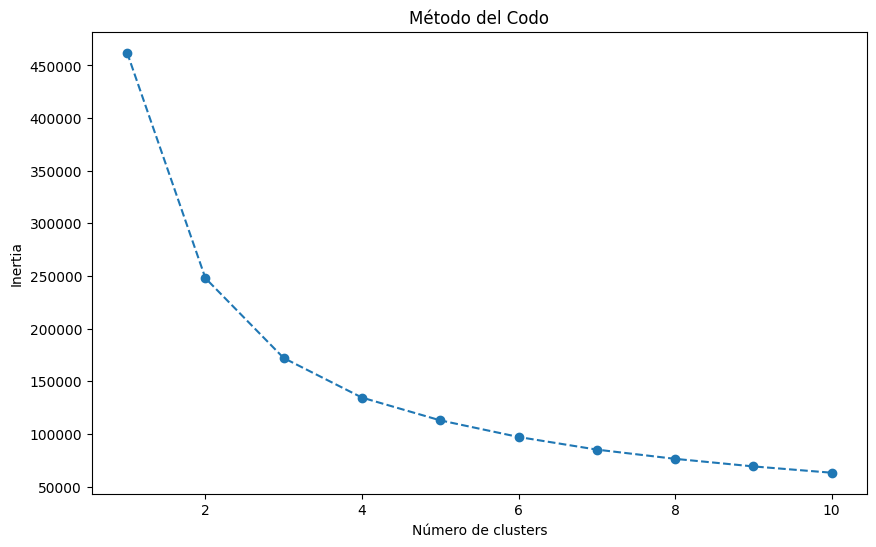

In [65]:
# 3. Determinar el número óptimo de clusters usando el método del codo y la métrica de silueta

# Método del codo
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método del Codo')
plt.xlabel('Número de clusters')
plt.ylabel('Inertia')
plt.show()

In [49]:
silhouette = []
for k in range(2, 6):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=10000,n_init=5, init='k-means++')
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette.append(score)

KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(2, 11), silhouette, marker='o', linestyle='--')
plt.title('Métrica de Silueta')
plt.xlabel('Número de clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [66]:
# Una vez determinado el número óptimo de clusters, realiza la clusterización final
optimal_clusters = 3 #np.argmax(silhouette) + 2  # +2 porque el rango empieza en 2
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
grouped['cluster'] = kmeans.fit_predict(scaled_features)

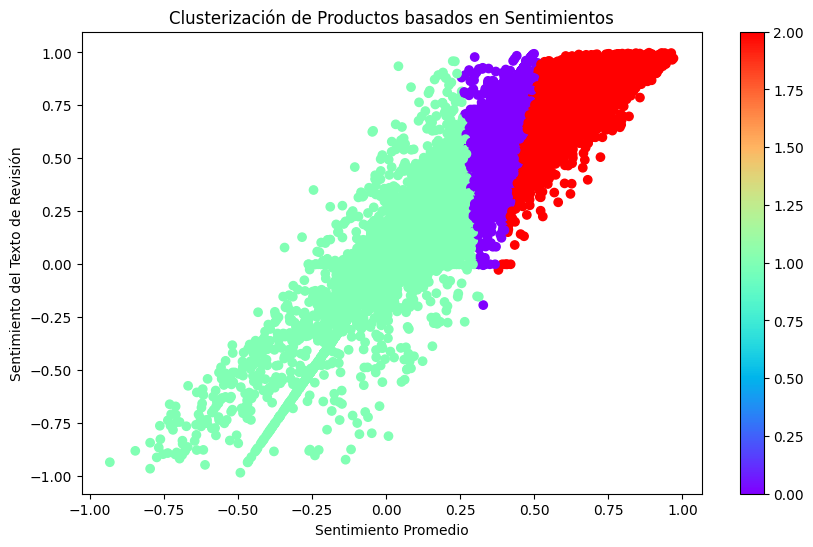

In [67]:
# Visualizar los resultados (puedes hacerlo con un pairplot o scatterplot, por ejemplo)
# En este caso, usaremos un scatterplot sencillo de 'average_sentiment' vs 'reviewText_sentiment'
plt.figure(figsize=(10,6))
plt.scatter(grouped['average_sentiment'], grouped['reviewText_sentiment'], c=grouped['cluster'], cmap='rainbow')
plt.title('Clusterización de Productos basados en Sentimientos')
plt.xlabel('Sentimiento Promedio')
plt.ylabel('Sentimiento del Texto de Revisión')
plt.colorbar()
plt.show()


Ejes:
Eje X - Sentimiento Promedio: Este eje representa el sentimiento promedio de las revisiones para un producto. Los valores van desde -1 a 1, donde:

-1 indica un sentimiento extremadamente negativo.
0 indica neutralidad en el sentimiento.
1 indica un sentimiento extremadamente positivo.
Eje Y - Sentimiento del Texto de Revisión: Este eje representa el sentimiento del texto completo de la revisión. Al igual que el eje X, los valores varían de -1 a 1, representando sentimientos desde extremadamente negativos hasta extremadamente positivos.

Interpretación:
Cluster Rojo: Los productos en este grupo tienden a tener revisiones que varían desde neutral hasta muy negativas en términos de sentimiento. En su mayoría, estos productos tienen una baja calificación de sentimiento promedio y un bajo sentimiento en el texto de la revisión.

Cluster Verde: Los productos en este cluster tienen revisiones con un sentimiento que varía desde neutral hasta positivo. Están en la parte media en términos de sentimiento promedio y sentimiento del texto de revisión.

Cluster Púrpura: Estos productos tienen revisiones con sentimientos predominantemente positivos. Tienen altos valores tanto para el sentimiento promedio como para el sentimiento del texto de la revisión.

Conclusiones:
Segmentación de Productos: Con esta clusterización, puedes segmentar tu conjunto de productos en aquellos que generalmente reciben críticas positivas, neutrales o negativas.

Toma de Decisiones: Si estás en una posición de tomar decisiones relacionadas con los productos, podrías considerar revisar más a fondo los productos en el cluster rojo para identificar problemas y áreas de mejora.

Estrategias de Marketing y Venta: Los productos en el cluster púrpura, que tienen críticas predominantemente positivas, podrían ser promocionados más intensamente, ya que es probable que sean bien recibidos por nuevos clientes.

Finalmente, es esencial considerar el contexto del negocio y el producto al interpretar estos resultados. Si bien la clusterización proporciona una visión general basada en sentimientos, siempre es útil combinar estos hallazgos con otras métricas y análisis cualitativos para obtener una comprensión completa.

In [52]:
grouped.head(5)

,asin,reviewText_sentiment,summary_sentiment,average_sentiment,cluster
0,0871167042,0.824267,0.195300,0.509783,1
1,1579652956,0.700300,0.158500,0.429400,1
2,5120053017,0.615840,0.231360,0.423600,1
3,5120053351,0.291567,-0.091067,0.100250,2
4,5780122040,0.615500,0.441650,0.528575,0
